# testing random forests on socio economic data

## import packages

In [116]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

## import datasets

In [189]:
df_unicef = pd.read_csv('clean data/unicef_socec_clean.csv', index_col=0)
df_aqua = pd.read_csv('clean data/aqua_socec_clean.csv', index_col=0)
df_stress = pd.read_csv('clean data/water_stress.csv')

## checking the datasets and combining with target variables

In [190]:
print(df_aqua.head(5))
print(df_unicef.head(5))


  country                                         variable     1998-2002  \
0     AFG                    Rural population (1000 inhab)  17086.910000   
1     AFG                    Urban population (1000 inhab)   4893.013000   
2     AFG                   Population density (inhab/km2)     34.618096   
3     AFG               GDP per capita (current US$/inhab)    194.958382   
4     AFG  Human Development Index (HDI) [highest = 1] (-)      0.378000   

      2003-2007     2008-2012     2013-2017  
0  20464.923000  23280.663000  26558.609000  
1   6151.869000   7416.295000   8971.472000  
2     41.510486     47.730564     55.595553  
3    389.985586    694.885618    605.557362  
4      0.431000      0.479000      0.493000  
                                  Indicator Country  Time  Value
0  Fertility rate, total (births per woman)     AUS  2000    1.8
1  Fertility rate, total (births per woman)     AUS  2001    1.7
2  Fertility rate, total (births per woman)     AUS  2002    1.8
3  Fert

### we modify the datasets to keep only useful variables
1. aquastat: keep rural & urban and make new variables rural/urban, also keep HDI
    * r_u : a variable that indicates the proportion of rural over urban population
    * r_u_access : a variable that indicates the proportion of the rural population with access to safe drinking water   
2. unicef: keep life expectancy, mortality rate, population growth, GDP per capita PPP
3. water stress: we use the water stress (MDG) and water efficiency as separate targets

In [191]:
cols_keep_aqua = ['Rural population (1000 inhab)', 'Urban population (1000 inhab)',
                  'Rural population with access to safe drinking-water (JMP) (%)',
                 'Urban population with access to safe drinking-water (JMP) (%)',
                 'Human Development Index (HDI) [highest = 1] (-)']
df_aqua = df_aqua[df_aqua.isin(cols_keep_aqua).any(axis=1)]

# rename year period to merge with water stress indicators
df_aqua.rename(columns = {'country':'Country' ,
                     '1998-2002':'2002', 
                     '2003-2007': '2007', 
                     '2008-2012': '2012',
                     '2013-2017':'2017'}, inplace = True)

df_aqua_melt = pd.melt(df_aqua, id_vars=["Country","variable"], 
        var_name="Year", 
        value_name="value")
# transform data aquastat wide format (indicators as attributes)
aqua_piv = df_aqua_melt.pivot_table(values='value', 
                             index=['Year','Country'], 
                             columns='variable',
                             fill_value=0)
aqua_piv = aqua_piv.reset_index()
aqua_piv.rename(columns = {'Human Development Index (HDI) [highest = 1] (-)': 'HDI',
                          'Rural population (1000 inhab)' : 'rural_pop',
                           'Urban population (1000 inhab)' : 'urban_pop',
                  'Rural population with access to safe drinking-water (JMP) (%)' : 'rural_water',
                 'Urban population with access to safe drinking-water (JMP) (%)' : 'urban_water'}, inplace=True)
# create new features
aqua_piv['r_u'] = aqua_piv['rural_pop']/aqua_piv['urban_pop']
aqua_piv['r_u_access'] = aqua_piv['rural_water']/aqua_piv['urban_water']
# final dataset
aqua_piv = aqua_piv[['Year', 'Country', 'HDI', 'r_u', 'r_u_access']]
aqua_piv.head()

variable,Year,Country,HDI,r_u,r_u_access
0,2002,AFG,0.378,3.492104,0.493739
1,2002,AGO,0.419,0.906176,0.591054
2,2002,ALB,0.680,1.298813,0.939698
3,2002,ARE,0.793,0.233552,1.004016
4,2002,ARG,0.770,0.117198,0.852342


In [192]:
aqua_piv.Year = aqua_piv.Year.astype(str)
df_stress.Year = df_stress.Year.astype(str)

df_piv_aqua = pd.merge(aqua_piv, df_stress, on=["Year", "Country"], how='left')
df_piv_aqua = df_piv_aqua.rename(columns = {'Water stress (MDG)' : 'stress', 'Water use efficiency (SDG)' : 'efficiency'})
df_piv_aqua = df_piv_aqua.drop(['Water stress (SDG)'], axis = 1)
df_piv_aqua.sample(5)

,Year,Country,HDI,r_u,r_u_access,stress,efficiency
122,2002,TGO,0.428,1.957816,0.461810,1.149660,9.733967
524,2017,PLW,0.811,0.260017,0.886598,NaN,NaN
133,2002,UZB,0.610,1.123673,0.846626,107.622263,0.472407
494,2017,LBY,0.704,0.252860,0.947295,817.142857,3.793108
430,2017,BEN,0.515,1.138215,0.846244,0.492611,27.261901


We now modify the unicef dataset

In [197]:
# keep only columns we'll need
df_unicef.rename(columns={'Time' : 'Year'}, inplace=True)
cols_keep_unicef = ['Life expectancy at birth, total (years)',
                   'Mortality rate, infant (per 1,000 live births)',
                   'Population growth (annual %)',
                   'GDP per capita, PPP (constant 2011 international $)']
df_unicef = df_unicef[df_unicef.isin(cols_keep_unicef).any(axis=1)]

# pivot so that indicators are variables
unicef_piv = df_unicef.pivot_table(values='Value', 
                             index=['Year','Country'], 
                             columns='Indicator',
                             fill_value=0)
# rename the columns for consistency
unicef_piv.rename(columns = {'Time':'Year' ,
                     'Life expectancy at birth, total (years)':'life_ex', 
                     'Mortality rate, infant (per 1,000 live births)': 'mort_rate', 
                     'Population growth (annual %)': 'pop_growth',
                     'GDP per capita, PPP (constant 2011 international $)': 'GDP_pcp' }, inplace = True)
unicef_piv = unicef_piv.reset_index()
unicef_piv.head(5)

Indicator,Year,Country,GDP_pcp,life_ex,mort_rate,pop_growth
0,2000,AFG,0,56,90,3.0
1,2000,AGO,4707,47,121,3.3
2,2000,ALB,6016,74,24,-0.6
3,2000,ARE,102495,74,10,5.5
4,2000,ARG,18625,74,18,1.1


#### we will only keep the rows matching with the water stress to just build the initial model, this will be changed later on

In [201]:
# keep only 2002, 2007, 2012, 2017 by doing a left join on the water stress data
unicef_piv.Year = unicef_piv.Year.astype(str)
df_stress.Year = df_stress.Year.astype(str)

df_piv_unicef = pd.merge(df_stress, unicef_piv, on=["Year", "Country"], how='left')
df_piv_unicef = df_piv_unicef.rename(columns = {'Water stress (MDG)' : 'stress', 'Water use efficiency (SDG)' : 'efficiency'})
df_piv_unicef = df_piv_unicef.drop(['Water stress (SDG)'], axis = 1)
df_piv_unicef.head(5)


,Country,Year,stress,efficiency,GDP_pcp,life_ex,mort_rate,pop_growth
0,AFG,2002,31.045462,0.305841,1273.0,57.0,85.0,4.5
1,AFG,2007,31.045462,0.547780,1563.0,59.0,72.0,2.5
2,AFG,2012,31.045462,0.765716,2220.0,62.0,60.0,3.4
3,AFG,2017,31.045462,0.923778,2203.0,64.0,50.0,2.5
4,AGO,2002,0.449137,66.804272,5218.0,48.0,114.0,3.3


### check the correlations with the target variables

In [66]:
corr_stress = df_piv_aqua.corr()['stress'].sort_values(ascending=False)
corr_effiency = df_piv_aqua.corr()['efficiency'].sort_values(ascending=False)
print('correlations with stress : \n', corr_stress)
print('correlations with effiency : \n', corr_effiency)

correlations with stress : 
 stress        1.000000
r_u_access    0.170128
HDI           0.147243
efficiency    0.087958
r_u          -0.136199
Name: stress, dtype: float64
correlations with effiency : 
 efficiency    1.000000
HDI           0.382652
r_u_access    0.231193
stress        0.087958
r_u          -0.245922
Name: efficiency, dtype: float64


In [67]:
# check for missing values
df_piv_aqua.isna().sum(axis=0)


Year           0
Country        0
HDI            0
r_u            0
r_u_access     0
stress        43
efficiency    99
dtype: int64

In [243]:
# remove empty rows from dataset
print(df_piv_aqua.shape)
df_piv_aqua = df_piv_aqua.dropna(axis=0)
df_piv_aqua.shape

(458, 7)


(458, 7)

In [280]:
# remove extreme outliers
df_piv_aqua = df_piv_aqua[df_piv_aqua.stress<=200]
df_piv_aqua = df_piv_aqua[df_piv_aqua.efficiency<=100]
print(df_piv_aqua.shape)
df_piv_aqua.describe()

(400, 7)


,HDI,r_u,r_u_access,stress,efficiency
count,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.635300,1.395715,0.809155,20.344616,18.003762
std,0.159448,1.448301,0.174173,32.514999,20.603029
min,0.263000,0.023080,0.259386,0.005529,0.244684
25%,0.503750,0.446730,0.695719,1.495824,3.975164
50%,0.654000,0.881602,0.856337,5.651860,9.825106
75%,0.752000,1.826508,0.950713,25.011522,23.861574
max,0.937000,10.518143,1.024084,187.092476,97.199458


do the same for the unicef dataset

In [281]:
corr_stress_u = df_piv_unicef.corr()['stress'].sort_values(ascending=False)
corr_effiency_u = df_piv_unicef.corr()['efficiency'].sort_values(ascending=False)
print('correlations with stress : \n', corr_stress_u)
print('correlations with effiency : \n', corr_effiency_u)

correlations with stress : 
 stress        1.000000
GDP_pcp       0.376563
pop_growth    0.266344
life_ex       0.129353
efficiency    0.087958
mort_rate    -0.156029
Name: stress, dtype: float64
correlations with effiency : 
 efficiency    1.000000
GDP_pcp       0.606117
life_ex       0.295399
stress        0.087958
pop_growth    0.033156
mort_rate    -0.262567
Name: efficiency, dtype: float64


GDP per capita, population growth, and mortatility rate are interesting variables for both target variables.
Also note that both target variables have very low correlation which makes it interesting to look at them.

In [282]:
# check for missing values, there are plenty
print(df_piv_unicef.isna().sum(axis=0))
# remove empty rows for now, we can do some imputation later on
df_piv_unicef = df_piv_unicef.dropna(axis=0)

Country       0
Year          0
stress        0
efficiency    0
GDP_pcp       0
life_ex       0
mort_rate     0
pop_growth    0
dtype: int64


In [289]:
# remove extreme values
df_piv_unicef = df_piv_unicef[df_piv_unicef.stress<=200]
df_piv_unicef = df_piv_unicef[df_piv_unicef.efficiency<=100]
print(df_piv_unicef.shape)
df_piv_unicef.describe()

(400, 8)


,stress,efficiency,GDP_pcp,life_ex,mort_rate,pop_growth
count,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000
mean,20.344616,18.003762,11988.610000,67.92250,33.572500,1.629500
std,32.514999,20.603029,13231.893043,9.24311,26.388266,1.276088
min,0.005529,0.244684,0.000000,41.00000,2.000000,-3.100000
25%,1.495824,3.975164,2668.750000,61.00000,13.000000,0.900000
50%,5.651860,9.825106,7248.000000,70.00000,25.000000,1.600000
75%,25.011522,23.861574,15123.000000,75.00000,50.250000,2.600000
max,187.092476,97.199458,59958.000000,83.00000,134.000000,7.800000


unicef dataset only has 400 entries when the extreme stress and efficiency values are removed, aquastat as well

we can therefore create a final dataset combining both

In [300]:
df_socio = pd.merge(df_piv_unicef, df_piv_aqua, on=["stress", "efficiency"], how='left')
df_socio.shape

(400, 13)

## modelling for aquastat

### Construct the tree

In [290]:
# Initialize the classifier, we will keep the default parameters for now
model_s = RandomForestRegressor()
model_e = RandomForestRegressor()

In [291]:
# define predictors and target
X = df_piv_aqua[['HDI', 'r_u', 'r_u_access']]
s = df_piv_aqua.stress.copy()
e = df_piv_aqua.efficiency.copy()

In [292]:
# split in train and test
X_train, X_test, s_train, s_test = train_test_split(X, s, test_size=0.2, random_state=0)
X2_train, X2_test, e_train, e_test = train_test_split(X, e, test_size=0.2, random_state=0)


In [293]:
model_s.fit(X_train,s_train);
model_e.fit(X2_train,e_train);

### Use the model to make a prediction

In [294]:
s_pred = model_s.predict(X_test)
e_pred = model_e.predict(X2_test)

In [295]:
print('Mean Absolute Error water stress:', metrics.mean_absolute_error(s_test, s_pred))
print('Mean Squared Error water stress:', metrics.mean_squared_error(s_test, s_pred))
print('Root Mean Squared Error water stress:', np.sqrt(metrics.mean_squared_error(s_test, s_pred)))

print('Mean Absolute Error efficiency:', metrics.mean_absolute_error(e_test, e_pred))
print('Mean Squared Error efficiency:', metrics.mean_squared_error(e_test, e_pred))
print('Root Mean Squared Error efficiency:', np.sqrt(metrics.mean_squared_error(e_test, e_pred)))

Mean Absolute Error water stress: 19.646271684687534
Mean Squared Error water stress: 930.9102094230235
Root Mean Squared Error water stress: 30.510821185655157
Mean Absolute Error efficiency: 10.432600199746103
Mean Squared Error efficiency: 257.79469264390974
Root Mean Squared Error efficiency: 16.055986193439185


Based on the fact that the water stress is given by underlyinh statstics, the model is not really good, though this is only using 3 variables

## modelling for unicef data

### Construct the tree

In [368]:
# Initialize the classifier, we will keep the default parameters for now
mod_s = RandomForestRegressor(n_estimators=20)
mod_e = RandomForestRegressor(n_estimators=20)

In [369]:
# define predictors and target
Xu = df_piv_unicef[['GDP_pcp', 'life_ex', 'mort_rate', 'pop_growth']]
su = df_piv_unicef.stress.copy()
eu = df_piv_unicef.efficiency.copy()

In [370]:
# split in train and test
Xu_train, Xu_test, su_train, su_test = train_test_split(Xu, su, test_size=0.1, random_state=0)
X2u_train, X2u_test, eu_train, eu_test = train_test_split(Xu, eu, test_size=0.1, random_state=0)


In [371]:
mod_s.fit(Xu_train,su_train)
mod_e.fit(X2u_train,eu_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

### use the model for predictions and check the errors

In [372]:
su_pred = mod_s.predict(Xu_test)
eu_pred = mod_e.predict(X2u_test)

In [373]:
print('Mean Absolute Error water stress:', metrics.mean_absolute_error(su_test, su_pred))
print('Mean Squared Error water stress:', metrics.mean_squared_error(su_test, su_pred))
print('Root Mean Squared Error water stress:', np.sqrt(metrics.mean_squared_error(su_test, su_pred)))

print('Mean Absolute Error efficiency:', metrics.mean_absolute_error(eu_test, eu_pred))
print('Mean Squared Error efficiency:', metrics.mean_squared_error(eu_test, eu_pred))
print('Root Mean Squared Error efficiency:', np.sqrt(metrics.mean_squared_error(eu_test, eu_pred)))

Mean Absolute Error water stress: 15.68393440025146
Mean Squared Error water stress: 558.6394923169989
Root Mean Squared Error water stress: 23.635555680309253
Mean Absolute Error efficiency: 9.4174212927945
Mean Squared Error efficiency: 222.55917004802322
Root Mean Squared Error efficiency: 14.918417142848071


clearly, this random forest sucks to predict the water stress, though the efficiency seems easier to predict

#### these bad predictions are in part due to the extreme values within stress and efficiency variables!!!

## modelling for all variables together

### Construct the tree

In [412]:
# Initialize the classifier, we will keep the default parameters for now
m_s = RandomForestRegressor(n_estimators=2000)
m_e = RandomForestRegressor(n_estimators=500)

In [413]:
# define predictors and target
x = df_socio[['GDP_pcp', 'life_ex', 'mort_rate', 'pop_growth','HDI', 'r_u', 'r_u_access']]
S = df_socio.stress.copy()
E = df_socio.efficiency.copy()

In [414]:
# split in train and test
x_train, x_test, S_train, S_test = train_test_split(x, S, test_size=0.1, random_state=0)
x2_train, x2_test, E_train, E_test = train_test_split(x, E, test_size=0.1, random_state=0)


In [415]:
m_s.fit(x_train,S_train);
m_e.fit(x2_train,E_train);

### Making predictions and checking errors

In [416]:
S_pred = m_s.predict(x_test)
E_pred = m_e.predict(x2_test)

In [417]:
print('Mean Absolute Error water stress:', metrics.mean_absolute_error(S_test, S_pred))
print('Mean Squared Error water stress:', metrics.mean_squared_error(S_test, S_pred))
print('Root Mean Squared Error water stress:', np.sqrt(metrics.mean_squared_error(S_test, S_pred)))

print('Mean Absolute Error efficiency:', metrics.mean_absolute_error(E_test, E_pred))
print('Mean Squared Error efficiency:', metrics.mean_squared_error(E_test, E_pred))
print('Root Mean Squared Error efficiency:', np.sqrt(metrics.mean_squared_error(E_test, E_pred)))

Mean Absolute Error water stress: 12.19172292318658
Mean Squared Error water stress: 336.2480067333211
Root Mean Squared Error water stress: 18.337066470221487
Mean Absolute Error efficiency: 7.802276262113514
Mean Squared Error efficiency: 122.33651919500385
Root Mean Squared Error efficiency: 11.060584034986753


given that we work on a scale of percentages, the mean absolute errors signify the errors we're getting

### further accuracy metrics

In [418]:
# Calculate the absolute errors
errors1 = abs(S_pred - S_test)
errors2 = abs(E_pred - E_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors1), 2), 'degrees.')
print('Mean Absolute Error:', round(np.mean(errors2), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape1 = 100 * (errors1 / S_test)
mape2 = 100 * (errors2 / E_test)

# Calculate and display accuracy
accuracy1 = 100 - np.median(mape1)
accuracy2 = 100 - np.median(mape2)

print('Accuracy water stress prediction:', round(accuracy1, 2), '%.')
print('Accuracy efficiency prediction:', round(accuracy2, 2), '%.')


Mean Absolute Error: 12.19 degrees.
Mean Absolute Error: 7.8 degrees.
Accuracy water stress prediction: 29.82 %.
Accuracy efficiency prediction: 46.64 %.


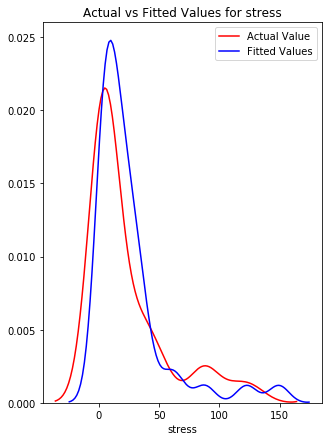

In [423]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 7))


ax = sns.distplot(S_test, hist=False, color="r", label="Actual Value")
sns.distplot(S_pred, hist=False, color="b", label="Fitted Values" , ax=ax)


plt.title('Actual vs Fitted Values for stress')


plt.show()
plt.close()